In [169]:
import pandas as pd
pd.options.mode.copy_on_write = True
import geopandas as gpd
#import geoplot
#import geoplot.crs as gcrs
#import contextily as ctx
#from catopy import crs as ccrs
import folium
from shapely import wkt
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas.tools

In this data question you will work with service request data related to missed trash pickups from hubNashville, Metro Nashville government's comprehensive customer service system.

Your goal is to practice working with dates, times, and time-based aggregation in pandas while exploring patterns in missed pickups. You’ll also calculate fines based on missed pickups within a rolling time window.

## Step 1: Data Preparation

In [119]:
# read 
trash = pd.read_csv('../data/trash_hauler_report_with_lat_lng.csv')
trash.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE
0,25270,11/1/2017,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292
1,25274,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470


#### 1. Convert any date columns to datetime using pd.to_datetime().

In [7]:
trash["Date Opened"] = pd.to_datetime(trash['Date Opened'], format = "%m/%d/%Y")

#### 2. Create new columns for:

#### year, month, day

#### day_of_week (or weekday name)

In [11]:
trash["Year"] = trash["Date Opened"].dt.year
trash["Month"] = trash["Date Opened"].dt.month
trash["Day"] = trash["Date Opened"].dt.day
trash["Day_of_Week"] = trash["Date Opened"].dt.day_name()

In [12]:
trash.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Year,Month,Day,Day_of_Week
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,2017,11,1,Wednesday
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday


In [13]:
trash["Request"].unique()

array(['Trash - Backdoor', 'Trash - Curbside/Alley Missed Pickup',
       'Trash Collection Complaint', 'Damage to Property'], dtype=object)

In [15]:
trash_damage = trash[trash.Request.str.contains('Damage to Property')]
trash_damage.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Year,Month,Day,Day_of_Week
6,25325,2017-11-01,Damage to Property,Trash/emptied Wednesday & now metal black-mail...,4721 Chalmers Dr,37215.0,RED RIVER,3303,34.0,1726300.965,637078.4022,-86.819640,36.080729,2017,11,1,Wednesday
173,26971,2017-11-08,Damage to Property,truck is cutting into yard and damaging lawn,717 garrison dr,37207.0,RED RIVER,3205,2.0,1727317.062,688538.0878,-86.817657,36.222107,2017,11,8,Wednesday


In [16]:
trash.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Year,Month,Day,Day_of_Week
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,2017,11,1,Wednesday
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday


In [17]:
trash_missed = trash[trash["Request"].isin(['Trash - Backdoor', 'Trash - Curbside/Alley Missed Pickup', 'Trash Collection Complaint'])]

In [18]:
trash_missed["Request"].unique()

array(['Trash - Backdoor', 'Trash - Curbside/Alley Missed Pickup',
       'Trash Collection Complaint'], dtype=object)

In [19]:
trash_missed["Description"][1000]

'MISSED PICK UP-Caller states this is an office building with 3 trash carts- caller states some items in cart are lose but that is the way the trash is normally picked up.'

In [20]:
trash_backdoor = trash[trash["Request"].isin(['Trash - Backdoor'])]

In [21]:
trash_backdoor["Description"]

0        house with the wheel chair ramp, they share dr...
55       Backdoor/miss for last Friday. Does not unders...
63       Missed trash pickup said has been picking up b...
71                                                 Missed.
78       Missed- she said her grandson was over yesterd...
                               ...                        
20165    HAS MISSED BACK DOOR TRASH PICK UP AGAIN/ ALSO...
20167                         MISSED BACKDOOR PICK UP HERE
20202                missed multiple times, please pick up
20205                        backdoor miss/ again Thursday
20218                           Friday/paid backdoor trash
Name: Description, Length: 2629, dtype: object

## Step 2: Explore Time-Based Patterns - 
Answer these simpler questions first:

#### Which day of the week has the highest number of missed pickups?

##### Thursday has the highest frequency of Request Number and Trash Hauler entries

In [25]:
trash_missed.groupby(["Day_of_Week"])["Request Number"].count()

Day_of_Week
Friday       4779
Monday       2561
Saturday      527
Sunday        194
Thursday     5008
Tuesday      2326
Wednesday    4574
Name: Request Number, dtype: int64

In [26]:
trash_missed["Day_of_Week"].value_counts()

Day_of_Week
Thursday     5008
Friday       4779
Wednesday    4574
Monday       2561
Tuesday      2326
Saturday      527
Sunday        194
Name: count, dtype: int64

In [27]:
trash_missed.groupby(["Day_of_Week"]).count().max()

Request Number      5008
Date Opened         5008
Request             5008
Description         5002
Incident Address    5007
Zip Code            4990
Trash Hauler        4816
Trash Route         4811
Council District    4992
State Plan X        5001
State Plan Y        5001
LONGITUDE           5001
LATITUDE            5001
Year                5008
Month               5008
Day                 5008
dtype: int64

#### Missed pickups over time:

#### Find the total number of missed pickups by month. Plot this with a line chart.

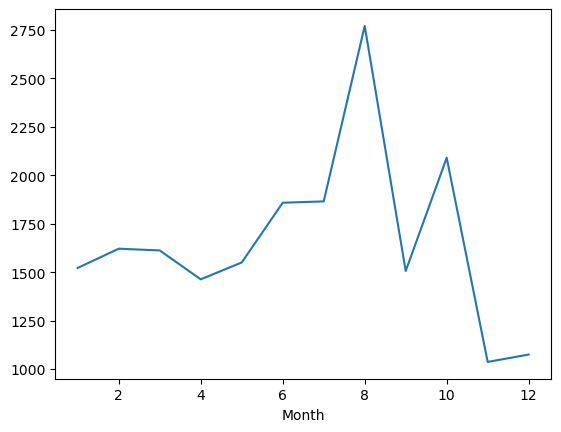

In [30]:
trash_missed.groupby('Month').size().plot();

In [31]:
trash_missed["Month"].value_counts()

Month
8     2770
10    2090
7     1865
6     1858
2     1621
3     1612
5     1550
1     1522
9     1506
4     1463
12    1075
11    1037
Name: count, dtype: int64

#### Create a plot showing the number of missed pickups per day.


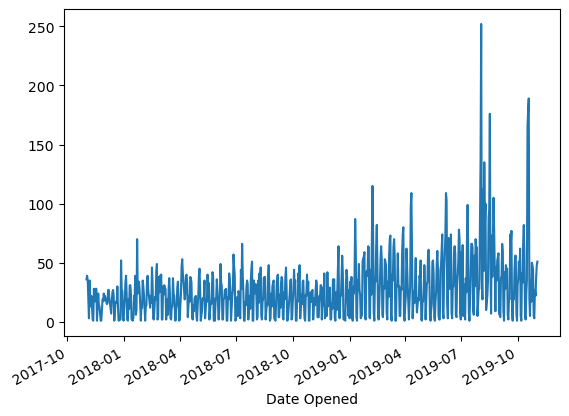

In [33]:
trash_missed.groupby('Date Opened').size().plot();

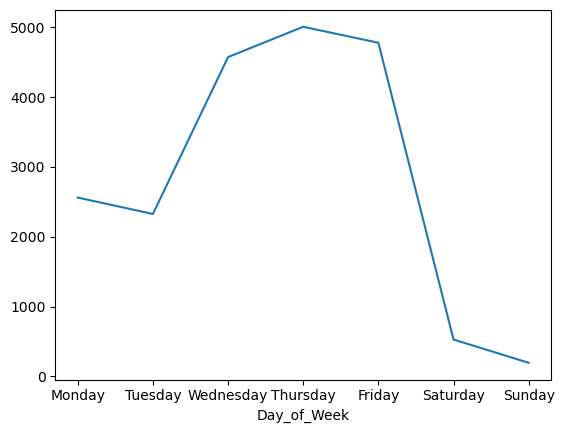

In [34]:
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
trash_missed.groupby('Day_of_Week').size().loc[day_order].plot();

In [35]:
trash_missed["Daily_Missed"] = trash_missed.groupby('Date Opened').transform("size")

In [36]:
trash_missed.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Year,Month,Day,Day_of_Week,Daily_Missed
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,2017,11,1,Wednesday,36
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday,36


#### Compute a rolling 30-day average of daily missed pickups. Visualize your results with a line chart to see trends.

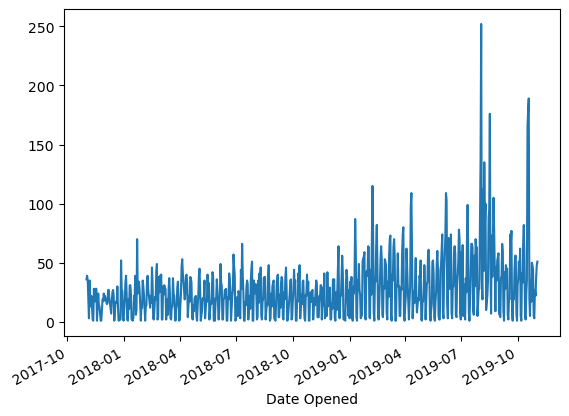

In [38]:
trash_missed.groupby('Date Opened').size().plot();

In [39]:
trash_missed.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Year,Month,Day,Day_of_Week,Daily_Missed
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,2017,11,1,Wednesday,36
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday,36


In [40]:
trash_missed['rolling_30D'] = trash_missed.rolling(window = '30D', on='Date Opened')['Daily_Missed'].mean()

<Axes: xlabel='Date Opened'>

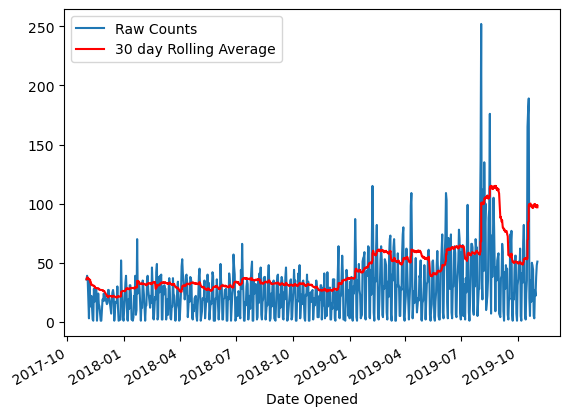

In [42]:
ax = trash_missed.plot(x='Date Opened', y='Daily_Missed', label= 'Raw Counts')
trash_missed.plot(x='Date Opened', y='rolling_30D', label= '30 day Rolling Average', color='red', ax=ax)

## Step 3: Main Task - 180-Day Rolling Fine Calculation

##### Metro Nashville charges fines for excessive missed trash pickups. It uses the following method to calculate the total fine: A $1500 fine is charged for each missed pickup that is the third or subsequent one at the same address within a 180-day window. Multiple fines may apply to the same address. What is the total fine across all addresses? Hint: The rolling method can be use in combination with groupby..

In [45]:
trash_missed.tail(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Year,Month,Day,Day_of_Week,Daily_Missed,rolling_30D
20224,267134,2019-11-01,Trash - Curbside/Alley Missed Pickup,Caller stated trash was missed & were only pic...,"3325 Murfreesboro Pike, Nashville, TN 37013, U...",37013.0,RED RIVER,4502,32.0,1785224.998,627146.4002,-86.620025,36.054637,2019,11,1,Friday,51,97.014306
20225,267137,2019-11-01,Trash - Curbside/Alley Missed Pickup,possibly others missed as well,"604 Somerset Ct, Nashville, TN 37217, United S...",37217.0,RED RIVER,2505,29.0,1781360.323,637742.0068,-86.633331,36.083675,2019,11,1,Friday,51,96.981415


In [46]:
trash_missed_drop = trash_missed[trash_missed["Incident Address"].notna()]

In [47]:
trash_sorted = trash_missed_drop\
  .set_index('Date Opened')\
  .sort_index()\
  .groupby('Incident Address')['Incident Address']\
  .rolling('180D')\
  .count()\
  .rename('Count_Over_180_Days')\
  .reset_index()

In [48]:
trash_sorted.head(2)

,Incident Address,Date Opened,Count_Over_180_Days
0,", Nashville, TN , United States",2018-07-05,1.0
1,1 BELLE FORREST AVE C,2018-06-29,1.0


In [49]:
trash_sorted["Count_Over_180_Days"] = trash_sorted["Count_Over_180_Days"].astype(int)
trash_three_or_more = trash_sorted[trash_sorted["Count_Over_180_Days"] >= 3]
trash_three_or_more["Finable_Times"] = trash_three_or_more["Count_Over_180_Days"] - 2
trash_three_or_more.head(2)

,Incident Address,Date Opened,Count_Over_180_Days,Finable_Times
35,"1000 2nd Ave N, Nashville, TN 37243, USA",2019-07-10,3,1
46,"1000 Trevino Pl, Antioch, Tennessee, 37013",2019-10-28,3,1


In [101]:
print(f"The total fine was around ${trash_three_or_more['Finable_Times'].count()*1500}.")

The total fine was around $3271500.


## BONUS

points_from_xy

In [123]:
geometry = gpd.points_from_xy(trash_missed.LONGITUDE, trash_missed.LATITUDE, crs="EPSG:4326")

In [200]:
geometry

<GeometryArray>
[<POINT (-86.8 36.2)>, <POINT (-86.8 36.2)>, <POINT (-86.9 36.1)>,
 <POINT (-86.8 36.2)>, <POINT (-86.9 36.2)>, <POINT (-86.7 36.1)>,
 <POINT (-86.8 36.2)>,   <POINT (-86.6 36)>, <POINT (-86.8 36.2)>,
 <POINT (-86.8 36.2)>,
 ...
 <POINT (-86.8 36.1)>, <POINT (-86.6 36.1)>, <POINT (-86.7 36.2)>,
 <POINT (-86.7 36.2)>, <POINT (-86.7 36.2)>, <POINT (-86.6 36.1)>,
 <POINT (-86.7 36.2)>, <POINT (-86.7 36.2)>, <POINT (-86.6 36.1)>,
 <POINT (-86.6 36.1)>]
Length: 19969, dtype: geometry

In [185]:
trash_missed["Geometry"] = pd.DataFrame(geometry)

In [202]:
trash_geo = gpd.GeoDataFrame(trash_missed, geometry="Geometry").head(2)

In [206]:
trash_geo.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,Year,Month,Day,Day_of_Week,Daily_Missed,rolling_30D,Geometry
0,25270,2017-11-01,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292,2017,11,1,Wednesday,36,36.0,POINT (-86.815 36.217)
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday,36,36.0,POINT (-86.838 36.213)


In [179]:
county = gpd.GeoDataFrame.from_file("../data/County_Boundary.shp")
county = county[["CountyArea", "geometry"]]

In [210]:
county

,CountyArea,geometry
0,0,"POLYGON ((1.81e+06 6.58e+05, 1.81e+06 6.58e+05..."
1,525,"POLYGON ((1.79e+06 6.95e+05, 1.79e+06 6.95e+05..."


In [222]:
#geo_fix = trash_geo.to_crs(county.crs)

In [224]:
#geo_fix

In [226]:
#gpd.tools.sjoin(trash_geo, county, how="left")